## Resnet18 + CIFAR10 on CPU/TPU/GPU using 'ignite'

In [ ]:
import os

gpu_gtg = False
if int(os.environ.get("COLAB_GPU")) > 0:
    gpu_gtg = "COLAB_GPU" in os.environ

tpu_gtg = "COLAB_TPU_ADDR" in os.environ

if tpu_gtg: # tpu
    print("TPU")
    #VERSION = "nightly"

    # https://github.com/pytorch/builder/pull/750
    VERSION = "20210304" 

    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $VERSION

TPU
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  98384      0 --:--:-- --:--:-- --:--:-- 98384
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20210304 ...
Found existing installation: torch 1.9.0+cu102
     |████████████████████████████████| 57 kB 1.9 MB/s 
Uninstalling torch-1.9.0+cu102:
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.272 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompa

In [ ]:
!pip install --pre pytorch-ignite

     |████████████████████████████████| 231 kB 5.5 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import torchsummary

import ignite
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.contrib.handlers import PiecewiseLinear
from ignite.engine import Engine, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.utils import manual_seed, setup_logger

In [ ]:
classes_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def training(local_rank, config, queue, **kwargs):
    print("local rank: ", local_rank)

    rank = idist.get_rank()
    print("----------> ", rank, ': run with config:', config, '- backend=', idist.backend())

    # For reproducibility
    # https://github.com/pytorch/pytorch/issues/2517
    torch.manual_seed(config["seed"] + rank)
    np.random.seed(config["seed"] + rank) 
    if gpu_gtg:
        torch.cuda.manual_seed(config["seed"] + rank)
        torch.cuda.manual_seed_all(config["seed"] + rank)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  

    train_transform = transforms.Compose(
    [
        transforms.Pad(4),
        transforms.RandomCrop(32, fill=128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    )

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

    if idist.get_local_rank() > 0:
        if config["verbose_loader"]:
            print(f"{idist.get_local_rank()} - rank non-zero barrier check") 
        idist.barrier()

    trainset = torchvision.datasets.CIFAR10(root=config["data_path"], train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root=config["data_path"], train=False, download=True, transform=test_transform)

    if config["verbose_loader"]:
        print(f"{idist.get_local_rank()} - dataset ready")

    if idist.get_local_rank() == 0:
        if config["verbose_loader"]:
            print(f"{idist.get_local_rank()} - rank zero barrier check")
        idist.barrier()

    trainloader = idist.auto_dataloader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"], drop_last=True)
    testloader = idist.auto_dataloader(testset, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"],)

    if config["verbose_loader"]:
        print(f"{idist.get_local_rank()} - dataloader ready")

    if config["verbose_loader"]:
        batch = next(iter(testloader))
        print(f"{idist.get_local_rank()} - \n {batch[1]}")      

    num_classes = 10
    model = models.resnet18(num_classes = num_classes)
    model = idist.auto_model(model)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(idist.device())

    trainer = create_supervised_trainer(model, optimizer, criterion, device=idist.device())
    trainer.logger = setup_logger("osmu-trainer")

    metrics = {
        'accuracy':Accuracy(),
        'ce':Loss(criterion),
        'cm':ConfusionMatrix(num_classes=num_classes)
    }

    train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=idist.device())
    train_evaluator.logger = setup_logger("osmu-train_evaluator")
    val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=idist.device())
    val_evaluator.logger = setup_logger("osmu-val_evaluator")

    training_history = {'accuracy':[],'loss':[]}
    validation_history = {'accuracy':[],'loss':[]}
    last_epoch = []

    # track a running average of the scalar loss output for each batch.
    RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

    def score_function(engine):
        val_loss = engine.state.metrics['ce']
        return -val_loss

    def early_stop():
        handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    
    val_evaluator.add_event_handler(Events.COMPLETED, early_stop)   

    checkpointer = ModelCheckpoint('./saved_models', 'cifar10', n_saved=2, create_dir=True, require_empty=False)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'cifar10': model})

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        train_evaluator.run(trainloader)
        metrics = train_evaluator.state.metrics
        accuracy = metrics['accuracy']*100
        loss = metrics['ce']
        last_epoch.append(0)
        training_history['accuracy'].append(accuracy)
        training_history['loss'].append(loss)
        print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
            .format(trainer.state.epoch, accuracy, loss))

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        val_evaluator.run(testloader)
        metrics = val_evaluator.state.metrics
        accuracy = metrics['accuracy']*100
        loss = metrics['ce']
        validation_history['accuracy'].append(accuracy)
        validation_history['loss'].append(loss)
        print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
            .format(trainer.state.epoch, accuracy, loss))

    # confusion matrix
    @trainer.on(Events.COMPLETED)
    def log_confusion_matrix(trainer):
        val_evaluator.run(testloader)
        metrics = val_evaluator.state.metrics
        cm = metrics['cm']
        print(cm)
        return
        cm = cm.numpy()
        cm = cm.astype(int)
        classes = classes_list
        fig, ax = plt.subplots(figsize=(10,10))  
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax,fmt="d")
        # labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels') 
        ax.set_title('Confusion Matrix') 
        ax.xaxis.set_ticklabels(classes,rotation=90)
        ax.yaxis.set_ticklabels(classes,rotation=0)

    print(f"{idist.get_local_rank()} - trainer")     

    trainer.run(trainloader, max_epochs=config["num_epochs"])
    
    if idist.get_local_rank() == 0:
        print(f"queue begins")     
        metrics = val_evaluator.state.metrics
        # 큐에 텐서를 넣을 수 없다!!! 
        import copy
        tmp = copy.deepcopy(metrics['cm'].numpy())
        queue.put(tmp)
        queue.put(training_history)
        queue.put(validation_history)
        queue.put(last_epoch)

        print(queue.qsize())


In [ ]:
config = {
    "seed": 543,
    "data_path" : "./cifar10",
    "output_path" : "./output-cifar10/",
    "model" : "resnet18",
    "batch_size" : 512,
    "momentum" : 0.9,
    "weight_decay" : 1e-4,
    "num_workers" : 2,
    "num_epochs" : 24,
    "learning_rate" : 0.4,
    "num_warmup_epochs" : 4,
    "validate_every" : 3, 
    "checkpoint_every" : 1000,
    "backend" : None, 
    "resume_from" : None, 
    "log_every_iters" : 15,
    "nproc_per_node" : None, 
    "stop_iteration" : None, 
    "with_amp" : False,
    "log_interval" : 10,
    "verbose_set" : False,
    "verbose_set2" : False,
    "verbose_loader" : False

}

if not (tpu_gtg or gpu_gtg): # cpu
    config["backend"] = 'gloo'
    config["nproc_per_node"] = 8
elif gpu_gtg: # gpu
    config["backend"] = 'nccl'
    config["nproc_per_node"] = 1
elif tpu_gtg: # tpu
    config["backend"] = 'xla-tpu'
    config["nproc_per_node"] = 8
else: # error
    raise RuntimeError("Unknown environment: tpu_gtg {}, gpu_gtg {}".format(tpu_gtg, gpu_gtg))

if config["backend"] == "xla-tpu" and config["with_amp"]:
    raise RuntimeError("The value of with_amp should be False if backend is xla")


dist_configs = {'nproc_per_node': config["nproc_per_node"], "start_method": "fork"}  # or dist_configs = {...}

from multiprocessing import Queue
queue = Queue()

with idist.Parallel(backend=config["backend"], **dist_configs) as parallel:
    parallel.run(training, config, queue, a=1, b=1)

    print(queue.qsize())
    cm = queue.get()
    training_history = queue.get()
    validation_history = queue.get()
    last_epoch = queue.get()


2021-07-20 04:29:39,145 ignite.distributed.launcher.Parallel INFO: Initialized distributed launcher with backend: 'xla-tpu'
2021-07-20 04:29:39,147 ignite.distributed.launcher.Parallel INFO: - Parameters to spawn processes: 
	nproc_per_node: 8
	nnodes: 1
	node_rank: 0
	start_method: fork
2021-07-20 04:29:39,150 ignite.distributed.launcher.Parallel INFO: Spawn function '<function training at 0x7f2812621f80>' in 8 processes


local rank:  7
local rank:  6
local rank:  3
---------->  6 : run with config: {'seed': 543, 'data_path': './cifar10', 'output_path': './output-cifar10/', 'model': 'resnet18', 'batch_size': 512, 'momentum': 0.9, 'weight_decay': 0.0001, 'num_workers': 2, 'num_epochs': 24, 'learning_rate': 0.4, 'num_warmup_epochs': 4, 'validate_every': 3, 'checkpoint_every': 1000, 'backend': 'xla-tpu', 'resume_from': None, 'log_every_iters': 15, 'nproc_per_node': 8, 'stop_iteration': None, 'with_amp': False, 'log_interval': 10, 'verbose_set': False, 'verbose_set2': False, 'verbose_loader': False} - backend= xla-tpu
local rank:  4
local rank:  5
local rank:  0
---------->  7 : run with config: {'seed': 543, 'data_path': './cifar10', 'output_path': './output-cifar10/', 'model': 'resnet18', 'batch_size': 512, 'momentum': 0.9, 'weight_decay': 0.0001, 'num_workers': 2, 'num_epochs': 24, 'learning_rate': 0.4, 'num_warmup_epochs': 4, 'validate_every': 3, 'checkpoint_every': 1000, 'backend': 'xla-tpu', 'resume_f


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


2021-07-20 04:30:07,089 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset CIFAR10': 
	{'batch_size': 64, 'num_workers': 2, 'drop_last': True, 'sampler': <torch.utils.data.distributed.DistributedSampler object at 0x7f28450f9110>, 'pin_memory': False}
2021-07-20 04:30:07,117 ignite.distributed.auto.auto_dataloader INFO: DataLoader is wrapped by `MpDeviceLoader` on XLA
2021-07-20 04:30:07,132 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset CIFAR10': 
	{'batch_size': 64, 'num_workers': 2, 'sampler': <torch.utils.data.distributed.DistributedSampler object at 0x7f280af2f750>, 'pin_memory': False}
2021-07-20 04:30:07,144 ignite.distributed.auto.auto_dataloader INFO: DataLoader is wrapped by `MpDeviceLoader` on XLA


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
before trainer:  xla:1
0 - trainer
0 - trainer.run begins
Files already downloaded and verified


2021-07-20 04:30:09,327 hkim-trainer INFO: Engine run starting with max_epochs=24.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
before trainer:  xla:0
5 - trainer
5 - trainer.run begins
before trainer:  xla:0
6 - trainer
6 - trainer.run begins
before trainer:  xla:0
7 - trainer
7 - trainer.run begins
before trainer:  xla:0
before trainer:  xla:0
1 - trainer
2 - trainer
1 - trainer.run begins
before trainer:  xla:0
2 - trainer.run begins
4 - trainer
4 - trainer.run begins
before trainer:  xla:0
3 - trainer
3 - trainer.run begins


2021-07-20 04:30:59,301 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86


2021-07-20 04:31:24,162 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86


2021-07-20 04:31:24,192 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86


2021-07-20 04:31:24,226 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83


2021-07-20 04:31:31,122 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07


Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83


2021-07-20 04:31:31,131 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:07


Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83


2021-07-20 04:31:31,174 hkim-trainer INFO: Epoch[1] Complete. Time taken: 00:01:22
2021-07-20 04:32:02,452 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66


2021-07-20 04:32:25,536 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-07-20 04:32:25,542 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:23


Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66


2021-07-20 04:32:25,566 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65


2021-07-20 04:32:29,713 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:32:29,745 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65


2021-07-20 04:32:29,775 hkim-trainer INFO: Epoch[2] Complete. Time taken: 00:00:59
2021-07-20 04:33:00,527 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-07-20 04:33:24,088 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-07-20 04:33:24,113 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-07-20 04:33:24,138 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-07-20 04:33:28,331 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-07-20 04:33:28,356 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-07-20 04:33:28,382 hkim-trainer INFO: Epoch[3] Complete. Time taken: 00:00:59
2021-07-20 04:33:59,301 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-07-20 04:34:22,865 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-07-20 04:34:22,879 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-07-20 04:34:22,911 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-07-20 04:34:27,076 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-07-20 04:34:27,087 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-07-20 04:34:27,109 hkim-trainer INFO: Epoch[4] Complete. Time taken: 00:00:59
2021-07-20 04:34:58,398 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41


2021-07-20 04:35:21,693 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-07-20 04:35:21,706 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:23


Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41


2021-07-20 04:35:21,740 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-07-20 04:35:26,039 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-07-20 04:35:26,068 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-07-20 04:35:26,098 hkim-trainer INFO: Epoch[5] Complete. Time taken: 00:00:59
2021-07-20 04:35:56,914 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36
Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36


2021-07-20 04:36:20,205 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-07-20 04:36:20,235 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:23


Training Results - Epoch: 6  Avg accuracy: 50.29 Avg loss: 1.36


2021-07-20 04:36:20,299 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42
Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42


2021-07-20 04:36:24,427 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:36:24,451 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 6  Avg accuracy: 48.47 Avg loss: 1.42


2021-07-20 04:36:24,496 hkim-trainer INFO: Epoch[6] Complete. Time taken: 00:00:58
2021-07-20 04:36:55,534 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33
Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33


2021-07-20 04:37:18,806 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23


Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33
Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33
Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33
Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33
Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33


2021-07-20 04:37:18,821 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:23


Training Results - Epoch: 7  Avg accuracy: 51.96 Avg loss: 1.33


2021-07-20 04:37:18,854 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40
Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40


2021-07-20 04:37:23,000 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40
Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40
Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40
Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40
Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40


2021-07-20 04:37:23,027 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 7  Avg accuracy: 49.87 Avg loss: 1.40


2021-07-20 04:37:23,053 hkim-trainer INFO: Epoch[7] Complete. Time taken: 00:00:59
2021-07-20 04:37:54,201 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28
Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28
Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28


2021-07-20 04:38:17,419 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23


Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28
Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28


2021-07-20 04:38:17,428 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:23


Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28
Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28
Training Results - Epoch: 8  Avg accuracy: 53.62 Avg loss: 1.28


2021-07-20 04:38:17,469 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37


2021-07-20 04:38:21,516 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:38:21,532 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37
Validation Results - Epoch: 8  Avg accuracy: 51.26 Avg loss: 1.37


2021-07-20 04:38:21,553 hkim-trainer INFO: Epoch[8] Complete. Time taken: 00:00:58
2021-07-20 04:38:55,820 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22
Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22
Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22
Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22
Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22
Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22


2021-07-20 04:39:20,073 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22


2021-07-20 04:39:20,103 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 9  Avg accuracy: 55.39 Avg loss: 1.22


2021-07-20 04:39:20,135 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.
2021-07-20 04:39:24,408 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31


2021-07-20 04:39:24,411 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31
Validation Results - Epoch: 9  Avg accuracy: 52.92 Avg loss: 1.31


2021-07-20 04:39:24,447 hkim-trainer INFO: Epoch[9] Complete. Time taken: 00:01:03
2021-07-20 04:39:57,401 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14
Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14


2021-07-20 04:40:21,642 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24
2021-07-20 04:40:21,674 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 10  Avg accuracy: 58.65 Avg loss: 1.14


2021-07-20 04:40:21,706 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26
Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26


2021-07-20 04:40:25,992 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:40:26,034 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 10  Avg accuracy: 54.92 Avg loss: 1.26


2021-07-20 04:40:26,062 hkim-trainer INFO: Epoch[10] Complete. Time taken: 00:01:02
2021-07-20 04:40:58,333 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12


2021-07-20 04:41:22,563 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12
Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12
Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12
Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12
Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12


2021-07-20 04:41:22,582 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12
Training Results - Epoch: 11  Avg accuracy: 59.72 Avg loss: 1.12


2021-07-20 04:41:22,602 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25
Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25
Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25
Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25
Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25
Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25


2021-07-20 04:41:26,872 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25


2021-07-20 04:41:26,898 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 11  Avg accuracy: 56.40 Avg loss: 1.25


2021-07-20 04:41:26,928 hkim-trainer INFO: Epoch[11] Complete. Time taken: 00:01:01
2021-07-20 04:41:59,293 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09
Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09
Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09
Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09


2021-07-20 04:42:23,398 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09
Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09
Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09


2021-07-20 04:42:23,415 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 12  Avg accuracy: 60.72 Avg loss: 1.09


2021-07-20 04:42:23,443 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23
Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23
Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23
Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23
Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23


2021-07-20 04:42:27,786 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23
Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23


2021-07-20 04:42:27,794 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 12  Avg accuracy: 56.80 Avg loss: 1.23


2021-07-20 04:42:27,827 hkim-trainer INFO: Epoch[12] Complete. Time taken: 00:01:01
2021-07-20 04:43:00,083 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11
Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11
Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11
Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11
Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11
Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11


2021-07-20 04:43:24,128 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11


2021-07-20 04:43:24,141 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 13  Avg accuracy: 60.58 Avg loss: 1.11


2021-07-20 04:43:24,177 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24


2021-07-20 04:43:28,436 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:43:28,460 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24
Validation Results - Epoch: 13  Avg accuracy: 56.39 Avg loss: 1.24


2021-07-20 04:43:28,491 hkim-trainer INFO: Epoch[13] Complete. Time taken: 00:01:01
2021-07-20 04:44:01,453 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04
Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04
Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04
Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04
Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04
Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04


2021-07-20 04:44:25,822 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04


2021-07-20 04:44:25,870 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 14  Avg accuracy: 62.42 Avg loss: 1.04


2021-07-20 04:44:25,899 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20
Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20


2021-07-20 04:44:30,197 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:44:30,230 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 14  Avg accuracy: 57.70 Avg loss: 1.20


2021-07-20 04:44:30,263 hkim-trainer INFO: Epoch[14] Complete. Time taken: 00:01:02
2021-07-20 04:45:02,438 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97
Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97
Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97
Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97
Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97
Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97


2021-07-20 04:45:26,915 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97


2021-07-20 04:45:26,951 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 15  Avg accuracy: 64.92 Avg loss: 0.97


2021-07-20 04:45:26,969 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16
Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16


2021-07-20 04:45:31,347 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16
Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16
Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16
Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16
Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16


2021-07-20 04:45:31,361 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 15  Avg accuracy: 59.48 Avg loss: 1.16


2021-07-20 04:45:31,391 hkim-trainer INFO: Epoch[15] Complete. Time taken: 00:01:01
2021-07-20 04:46:04,197 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03


2021-07-20 04:46:28,272 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03
Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03
Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03
Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03
Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03
Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03


2021-07-20 04:46:28,296 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 16  Avg accuracy: 63.22 Avg loss: 1.03


2021-07-20 04:46:28,319 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23
Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23


2021-07-20 04:46:32,614 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:46:32,642 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 16  Avg accuracy: 57.89 Avg loss: 1.23


2021-07-20 04:46:32,691 hkim-trainer INFO: Epoch[16] Complete. Time taken: 00:01:01
2021-07-20 04:47:05,342 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95
Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95
Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95
Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95


2021-07-20 04:47:29,783 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95
Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95
Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95


2021-07-20 04:47:29,798 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 17  Avg accuracy: 65.51 Avg loss: 0.95


2021-07-20 04:47:29,840 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16
Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16
Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16


2021-07-20 04:47:34,171 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16


2021-07-20 04:47:34,179 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16
Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16
Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16
Validation Results - Epoch: 17  Avg accuracy: 60.30 Avg loss: 1.16


2021-07-20 04:47:34,201 hkim-trainer INFO: Epoch[17] Complete. Time taken: 00:01:01
2021-07-20 04:48:06,502 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94
Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94
Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94
Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94
Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94
Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94


2021-07-20 04:48:30,854 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94


2021-07-20 04:48:30,886 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 18  Avg accuracy: 66.29 Avg loss: 0.94


2021-07-20 04:48:30,927 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19
Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19
Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19
Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19
Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19


2021-07-20 04:48:35,321 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19
Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19


2021-07-20 04:48:35,333 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 18  Avg accuracy: 59.85 Avg loss: 1.19


2021-07-20 04:48:35,360 hkim-trainer INFO: Epoch[18] Complete. Time taken: 00:01:01
2021-07-20 04:49:12,028 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93
Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93


2021-07-20 04:49:37,278 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93


2021-07-20 04:49:37,285 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93
Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93
Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93
Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93
Training Results - Epoch: 19  Avg accuracy: 66.44 Avg loss: 0.93


2021-07-20 04:49:37,303 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18
Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18


2021-07-20 04:49:41,715 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18
Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18
Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18
Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18
Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18


2021-07-20 04:49:41,749 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 19  Avg accuracy: 60.20 Avg loss: 1.18


2021-07-20 04:49:41,781 hkim-trainer INFO: Epoch[19] Complete. Time taken: 00:01:06
2021-07-20 04:50:15,025 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94
Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94
Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94
Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94


2021-07-20 04:50:39,654 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94
Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94
Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94


2021-07-20 04:50:39,669 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 20  Avg accuracy: 66.52 Avg loss: 0.94


2021-07-20 04:50:39,702 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23
Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23
Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23
Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23


2021-07-20 04:50:44,182 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23
Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23
Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23


2021-07-20 04:50:44,203 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 20  Avg accuracy: 58.84 Avg loss: 1.23


2021-07-20 04:50:44,235 hkim-trainer INFO: Epoch[20] Complete. Time taken: 00:01:02
2021-07-20 04:51:17,002 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87
Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87
Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87


2021-07-20 04:51:41,667 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87
Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87
Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87
Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87


2021-07-20 04:51:41,694 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 21  Avg accuracy: 68.81 Avg loss: 0.87


2021-07-20 04:51:41,733 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17


2021-07-20 04:51:46,150 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17
Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17
Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17
Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17


2021-07-20 04:51:46,166 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17
Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17
Validation Results - Epoch: 21  Avg accuracy: 60.46 Avg loss: 1.17


2021-07-20 04:51:46,194 hkim-trainer INFO: Epoch[21] Complete. Time taken: 00:01:02
2021-07-20 04:52:18,986 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88
Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88
Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88
Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88
Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88
Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88


2021-07-20 04:52:43,757 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88


2021-07-20 04:52:43,777 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 22  Avg accuracy: 68.50 Avg loss: 0.88


2021-07-20 04:52:43,798 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21
Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21


2021-07-20 04:52:48,223 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:52:48,250 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 22  Avg accuracy: 60.36 Avg loss: 1.21


2021-07-20 04:52:48,275 hkim-trainer INFO: Epoch[22] Complete. Time taken: 00:01:02
2021-07-20 04:53:20,903 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.
2021-07-20 04:53:45,648 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87


2021-07-20 04:53:45,657 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87
Training Results - Epoch: 23  Avg accuracy: 68.87 Avg loss: 0.87


2021-07-20 04:53:45,683 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21


2021-07-20 04:53:50,049 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04
2021-07-20 04:53:50,067 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21
Validation Results - Epoch: 23  Avg accuracy: 60.23 Avg loss: 1.21


2021-07-20 04:53:50,111 hkim-trainer INFO: Epoch[23] Complete. Time taken: 00:01:02
2021-07-20 04:54:22,666 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80
Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80
Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80
Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80


2021-07-20 04:54:47,715 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:25


Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80
Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80
Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80


2021-07-20 04:54:47,744 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:25


Training Results - Epoch: 24  Avg accuracy: 71.40 Avg loss: 0.80


2021-07-20 04:54:47,781 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16
Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16
Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16


2021-07-20 04:54:52,305 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16
Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16
Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16
Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16


2021-07-20 04:54:52,327 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:05


Validation Results - Epoch: 24  Avg accuracy: 62.04 Avg loss: 1.16


2021-07-20 04:54:52,362 hkim-trainer INFO: Epoch[24] Complete. Time taken: 00:01:02
2021-07-20 04:54:52,391 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


tensor([[622,  29,  97,  20,  30,  18,  10,   7, 121,  46],
        [ 48, 696,  15,  14,   1,   5,  19,   5,  62, 135],
        [ 75,   8, 488,  39, 117, 102, 105,  24,  24,  18],
        [ 31,  12,  71, 331,  75, 271, 122,  40,  27,  20],
        [ 41,   7,  71,  39, 583,  67, 106,  65,  12,   9],
        [ 23,   6,  55, 125,  53, 623,  55,  39,  11,  10],
        [ 10,   9,  57,  52,  34,  37, 776,   3,  11,  11],
        [ 31,  10,  34,  25,  94, 117,  21, 625,   7,  36],
        [ 72,  34,  18,  13,  10,   9,   4,   5, 802,  33],
        [ 50, 128,   9,  23,  15,   9,  20,   8,  80, 658]])tensor([[622,  29,  97,  20,  30,  18,  10,   7, 121,  46],
        [ 48, 696,  15,  14,   1,   5,  19,   5,  62, 135],
        [ 75,   8, 488,  39, 117, 102, 105,  24,  24,  18],
        [ 31,  12,  71, 331,  75, 271, 122,  40,  27,  20],
        [ 41,   7,  71,  39, 583,  67, 106,  65,  12,   9],
        [ 23,   6,  55, 125,  53, 623,  55,  39,  11,  10],
        [ 10,   9,  57,  52,  34,  37, 7

2021-07-20 04:54:56,787 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04





3 - trainer.run ends



7 - trainer.run ends
2 - trainer.run ends
6 - trainer.run ends
5 - trainer.run ends


2021-07-20 04:54:56,828 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


1 - trainer.run ends
4 - trainer.run ends
tensor([[622,  29,  97,  20,  30,  18,  10,   7, 121,  46],
        [ 48, 696,  15,  14,   1,   5,  19,   5,  62, 135],
        [ 75,   8, 488,  39, 117, 102, 105,  24,  24,  18],
        [ 31,  12,  71, 331,  75, 271, 122,  40,  27,  20],
        [ 41,   7,  71,  39, 583,  67, 106,  65,  12,   9],
        [ 23,   6,  55, 125,  53, 623,  55,  39,  11,  10],
        [ 10,   9,  57,  52,  34,  37, 776,   3,  11,  11],
        [ 31,  10,  34,  25,  94, 117,  21, 625,   7,  36],
        [ 72,  34,  18,  13,  10,   9,   4,   5, 802,  33],
        [ 50, 128,   9,  23,  15,   9,  20,   8,  80, 658]])


2021-07-20 04:54:56,932 hkim-trainer INFO: Engine run complete. Time taken: 00:24:48


0 - trainer.run ends
queue begins
4


2021-07-20 04:54:57,076 ignite.distributed.launcher.Parallel INFO: End of run


4


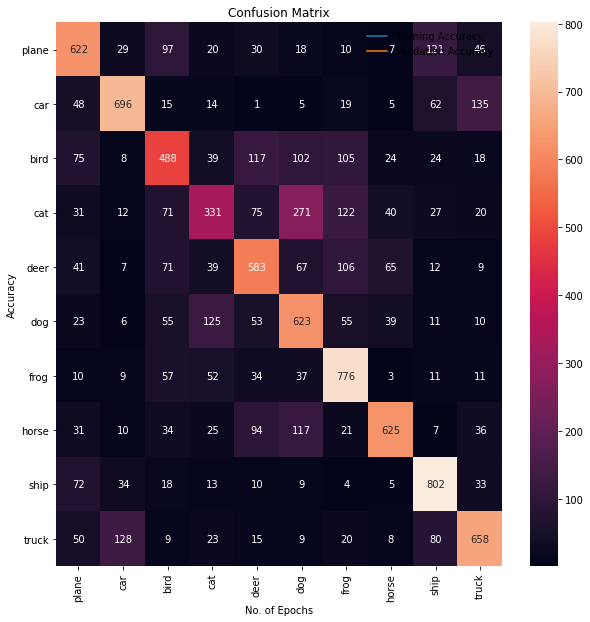

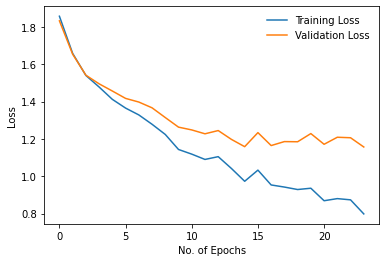

hkim - 777 
Model Loaded
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([ 2.5730,  1.3642, -0.7973, -2.0888,  1.5838, -3.6826, -4.0539, -1.8805,
        -0.4597,  1.8055], grad_fn=<SelectBackward>)


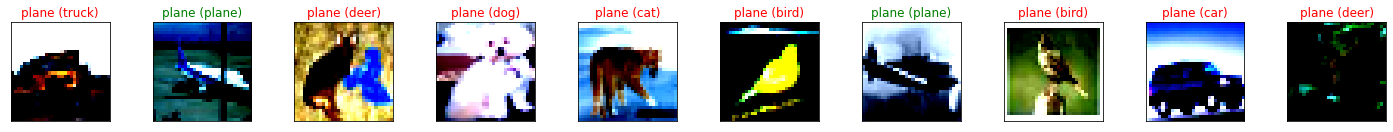

In [ ]:
 # 1. confusion matrix
cm = cm.astype(int)
classes = classes_list
fig, ax = plt.subplots(figsize=(10,10))  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)


# 2. learning curve
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()


# 3. load the saved model and draw sample prediction results
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model = models.resnet18()
num_classes = 10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")    


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
testset = torchvision.datasets.CIFAR10(root=config["data_path"], train=False, download=True, transform=test_transform)
# not autoloader this time...
testloader = torch.utils.data.DataLoader(testset, batch_size=config["batch_size"], shuffle=True)

images, labels = next(iter(testloader))

model.to(idist.device())

preds = model(images.to(idist.device()))

preds = preds.cpu()
print(preds[0])

# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    best = np.argmax(preds[0].detach().numpy())
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes_list[best], classes_list[labels[i]]),
                color=("green" if best==labels[i] else "red"))   

## License




---


author: John H. Kim<br>
email: john.kim@lgresearch.ai / secutron@naver.com


---


Copyright 2021 LG AI Research

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official LG AI Research product but sample code provided for an educational purpose
